In [1]:
import pandas as pd
df = pd.read_csv("/Users/channa/Projects/heavywater/document-classification-test/shuffled-full-set-hashed.csv", 
            names = ['class', 'doc'])
df.dropna(inplace = True)
df.head()

,class,doc
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


In [2]:
from io import StringIO

df['class_id'] = df['class'].factorize()[0]
class_id_df = df[['class', 'class_id']].drop_duplicates().sort_values('class_id')
class_id = dict(class_id_df.values)
id_to_class = dict(class_id_df[['class_id', 'class']].values)

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('class').doc.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, norm='l2', 
                        encoding='latin-1', ngram_range=(1, 2), 
                        max_features = 2000)

features = tfidf.fit_transform(df.doc).toarray()
labels = df.class_id
features.shape


(62159, 2000)

In [22]:
features

array([[0.        , 0.        , 0.        , ..., 0.04961519, 0.        ,
        0.05061715],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.07446436, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.11190478, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# from sklearn.feature_selection import chi2
# import numpy as np

# N = 2
# for doc, class_id in sorted(class_id.items()):
#   features_chi2 = chi2(features, labels == class_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("# '{}':".format(doc))
#   print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['doc'], df['class'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


/Users/channa/.local/share/virtualenvs/heavywater-eXBfxq3K/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/channa/.local/share/virtualenvs/heavywater-eXBfxq3K/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/channa/.local/share/virtualenvs/heavywater-eXBfxq3K/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/channa/.local/share/virtualenvs/heavywater-eXBfxq3K/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_cl

In [6]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.619924
1,RandomForestClassifier,1,0.620185
2,RandomForestClassifier,2,0.615106
3,RandomForestClassifier,3,0.610280
4,RandomForestClassifier,4,0.628834
5,LinearSVC,0,0.876256
6,LinearSVC,1,0.870205
7,LinearSVC,2,0.874678
8,LinearSVC,3,0.876770
9,LinearSVC,4,0.874346


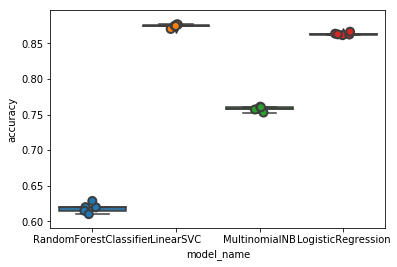

In [8]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

## accuracy comparison of multiple models

In [7]:
print(cv_df.groupby('model_name').accuracy.mean())

model_name
LinearSVC                 0.874451
LogisticRegression        0.863254
MultinomialNB             0.757880
RandomForestClassifier    0.618866
Name: accuracy, dtype: float64


In [11]:
from sklearn.model_selection import train_test_split
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)


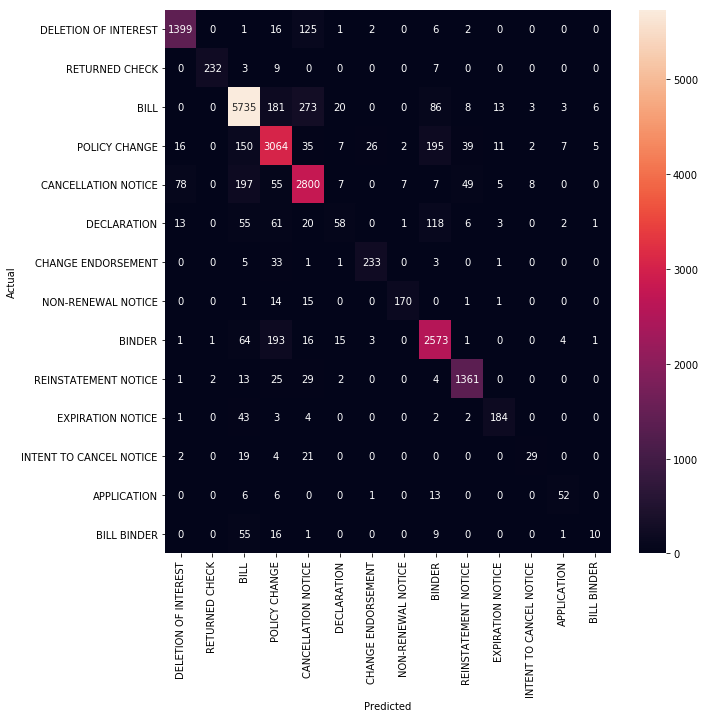

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_id_df['class'].values, yticklabels=class_id_df['class'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()